### Installing needed packages, using specific versions to avoid warnings

In [114]:
!pip install gym
!pip install matplotlib==3.1.3
!pip install pandas==1.0.3
!pip uninstall numpy -y
!pip install numpy==1.18


Found existing installation: numpy 1.18.0
Uninstalling numpy-1.18.0:
  Successfully uninstalled numpy-1.18.0
  Using cached numpy-1.18.0-cp38-cp38-win_amd64.whl.metadata (2.1 kB)
Using cached numpy-1.18.0-cp38-cp38-win_amd64.whl (12.8 MB)


# Initialize the Environment

In [21]:
%matplotlib inline

import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt  # Importing pyplot directly
import numpy as np
import pandas as pd
import sys


if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

env = CliffWalkingEnv()

In [2]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [3]:
# Parameters for Q-learning
num_episodes = 500
gamma = 0.999  # discount factor
alpha = 0.3  # learning rate
epsilon = 0.1  # exploration probability

# Q-Learning implementation & Plot

In [4]:
def q_learning(env, num_episodes, discount_factor, alpha, epsilon):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

Episode 500/500.

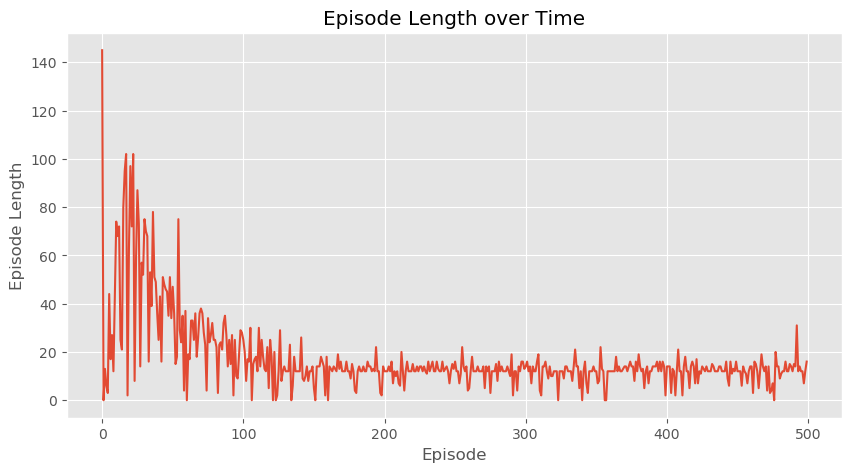

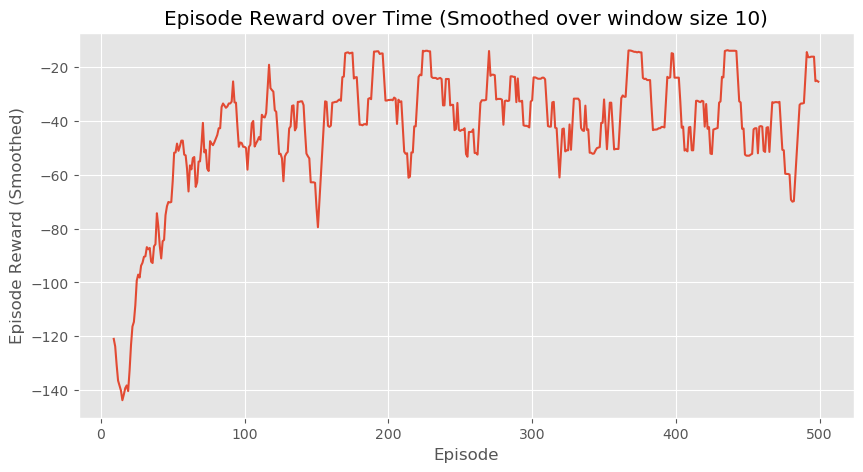

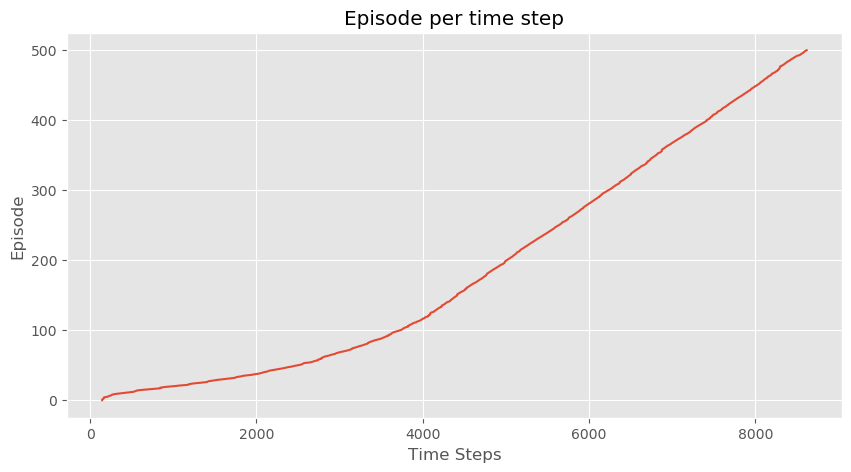

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [5]:
# Run Q-learning
Q, stats = q_learning(env, num_episodes, gamma, alpha, epsilon)
plotting.plot_episode_stats(stats)

# SARSA Implementation & Plot

In [11]:
def sarsa(env, num_episodes, discount_factor, alpha, epsilon):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

   # policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    for i_episode in range(num_episodes):
        state = env.reset()
        action_probs = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        for t in itertools.count():
            next_state, reward, done, _ = env.step(action)
            next_action_probs = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            if done:
                break

            action = next_action
            state = next_state

    return Q, stats


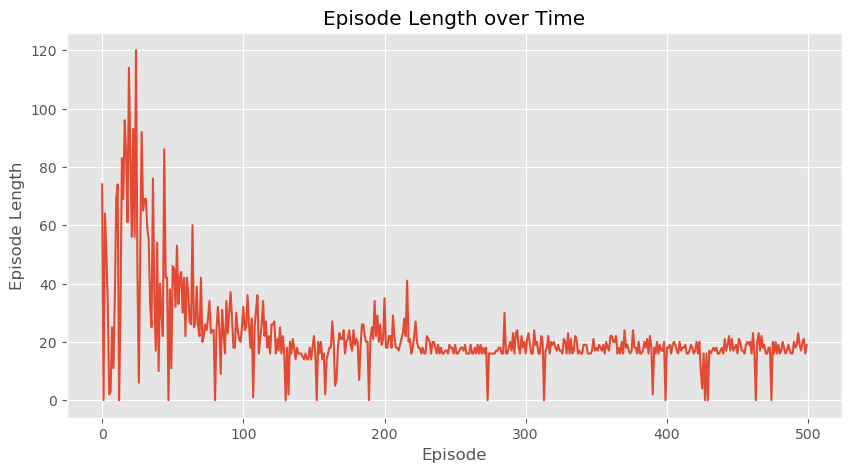

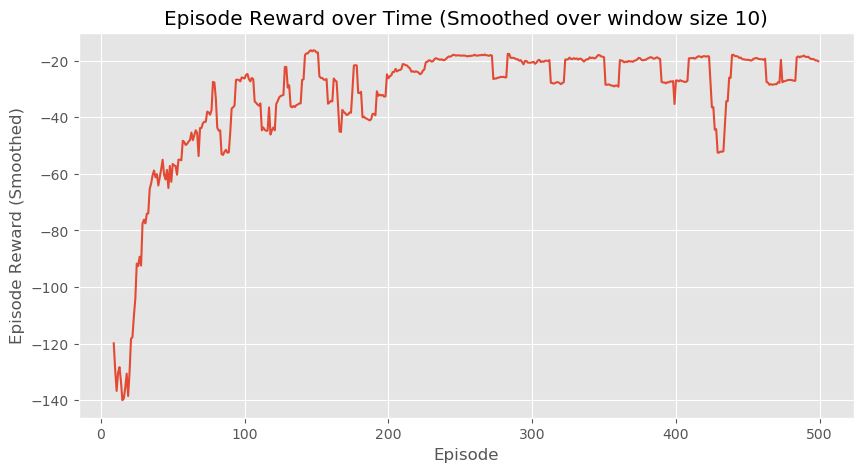

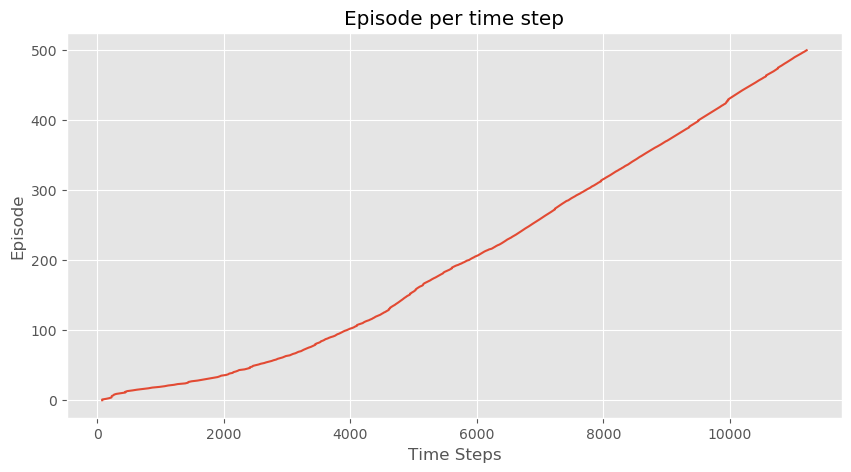

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [12]:
# Run SARSA
Q_sarsa, stats_sarsa = sarsa(env, num_episodes, gamma, alpha, epsilon)

plotting.plot_episode_stats(stats_sarsa)

# Comparison

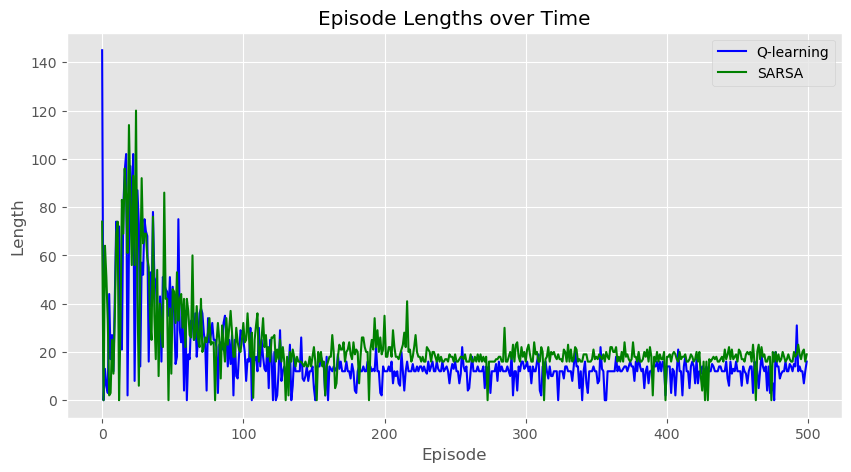

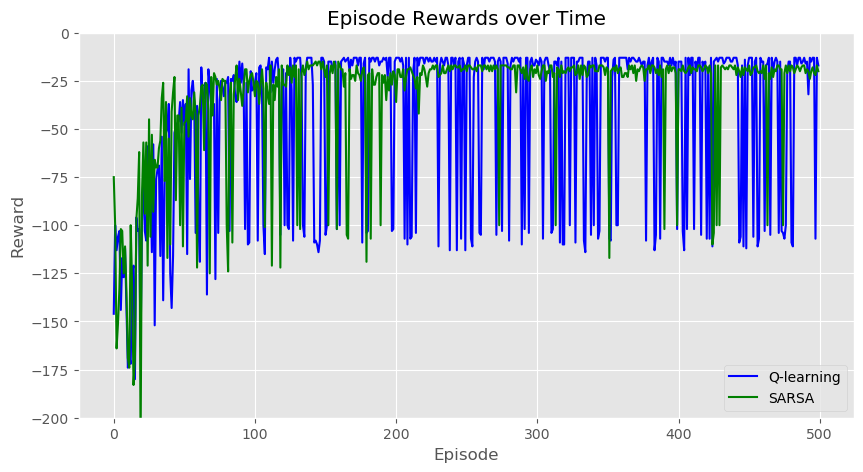

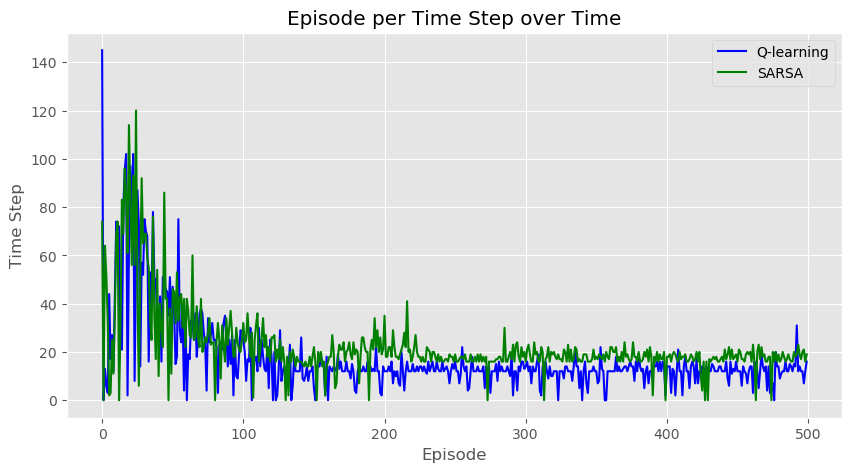

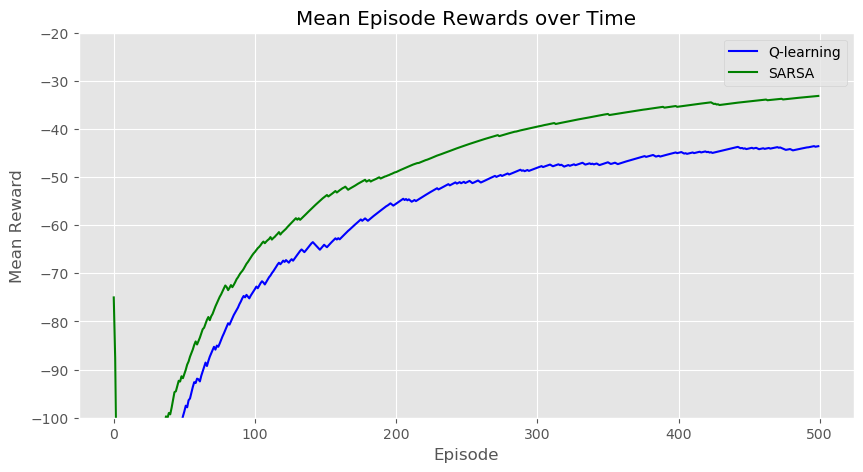

In [22]:
def plot_comparison(stats_q_learning, stats_sarsa):
    """
    Plot comparison of episode statistics for Q-learning and SARSA.

    Args:
        stats_q_learning: EpisodeStats object for Q-learning.
        stats_sarsa: EpisodeStats object for SARSA.
    """
    # Plot episode lengths
    plt.figure(figsize=(10, 5))
    plt.plot(stats_q_learning.episode_lengths, label='Q-learning', color='blue')
    plt.plot(stats_sarsa.episode_lengths, label='SARSA', color='green')
    plt.title('Episode Lengths over Time')
    plt.xlabel('Episode')
    plt.ylabel('Length')
    plt.legend()
    plt.show()

    # Plot episode rewards
    plt.figure(figsize=(10, 5))
    plt.plot(stats_q_learning.episode_rewards, label='Q-learning', color='blue')
    plt.plot(stats_sarsa.episode_rewards, label='SARSA', color='green')
    plt.title('Episode Rewards over Time')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.ylim(-200, 0)  # Set the y-axis range
    plt.show()

    # Plot episode per time step
    plt.figure(figsize=(10, 5))
    plt.plot(stats_q_learning.episode_lengths, label='Q-learning', color='blue')
    plt.plot(stats_sarsa.episode_lengths, label='SARSA', color='green')
    plt.title('Episode per Time Step over Time')
    plt.xlabel('Episode')
    plt.ylabel('Time Step')
    plt.legend()
    plt.show()

    # Calculate mean episode rewards over time
    mean_rewards_q_learning = np.cumsum(stats_q_learning.episode_rewards) / (np.arange(len(stats_q_learning.episode_rewards)) + 1)
    mean_rewards_sarsa = np.cumsum(stats_sarsa.episode_rewards) / (np.arange(len(stats_sarsa.episode_rewards)) + 1)

    # Plot mean episode rewards
    plt.figure(figsize=(10, 5))
    plt.plot(mean_rewards_q_learning, label='Q-learning', color='blue')
    plt.plot(mean_rewards_sarsa, label='SARSA', color='green')
    plt.title('Mean Episode Rewards over Time')
    plt.xlabel('Episode')
    plt.ylabel('Mean Reward')
    plt.legend()
    plt.ylim(-100, -20)  # Set the y-axis range
    plt.show()

# Plot comparison
plot_comparison(stats, stats_sarsa)
